# Tower A 2D Demo (Laplace + PINN)

This notebook flattens the Tower A geometry contract into a 2D x-z slice so we can explore basis fields, superposition, and a lightweight PINN workflow end-to-end.

**What you get**

- Geometry faithful to Tower A: x in [-6, 6] mm, z in [0, 12] mm with the electrode on z=0 and the gauge cap on z=12 mm.
- Finite-difference Laplace solver for single contacts plus utilities for multiple electrodes and superposition.
- |E| heatmaps with vector arrows so you can inspect basis fields visually.
- A compact `TowerA2DProblem` that wires PINA's `SpatialProblem`, Dirichlet, and Neumann conditions for this 2D slice.
- Helper functions to discretise, train, and evaluate 2D basis fields with PINA for rapid inference.

All coordinates are millimetres; fields are in arbitrary units because we only enforce the PDE + boundary conditions.

In [1]:
import os
from dataclasses import dataclass
from typing import Dict, List, Optional, Sequence, Tuple

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import torch
import torch.nn as nn
import torch._dynamo

from pina import Condition, LabelTensor
from pina.domain import CartesianDomain
from pina.equation import Equation, FixedValue
from pina.model import FeedForward
from pina.operator import div, grad
from pina.problem import SpatialProblem
from pina.solver.physics_informed_solver import PINN
from pina.trainer import Trainer
from lightning.pytorch.callbacks import EarlyStopping

torch._dynamo.config.disable = True
torch._dynamo.config.suppress_errors = True
os.environ.setdefault("TORCH_COMPILE_DISABLE", "1")

if torch.cuda.is_available():
    torch.set_float32_matmul_precision("high")

plt.rcParams.update({
    "figure.figsize": (7, 5),
    "image.origin": "lower",
    "axes.grid": False,
})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda



- The domain represents a vertical slice through the thalamic tissue block.  
- The **array plane** (electrode contacts) lies at **z = 0 mm**.  
- The tissue extends **upward (+Z)** to **z = 12 mm**, where the **gauge (ground)** patch is located.  
- Along the **X-axis**, the model spans ±6 mm to capture lateral field spread.

A uniform grid (`Nx × Nz`) is generated for this 2-D domain;  
each node corresponds to one sampling point for the Laplace/PINN field solver.


In [2]:
# --- Geometry parameters (mm) ---
Lx_mm = 12.0 # total lateral width
Lz_mm = 12.0 # total depth

# Define coordinate limits
x_min, x_max = -Lx_mm / 2, Lx_mm / 2
z_min, z_max = 0.0, Lz_mm

contact_radius_mm = 0.2  # Tower A contact radius
gauge_radius_mm = 1.5      # Top gauge half-width

#resolution
Nx = 461
Nz = 461

x = np.linspace(x_min, x_max, Nx)
z = np.linspace(z_min, z_max, Nz)
dx = float(x[1] - x[0])
dz = float(z[1] - z[0])

X, Z = np.meshgrid(x, z, indexing="ij")

print(f"dx = {dx:.4f} mm, dz = {dz:.4f} mm  (grid: {Nx} x-nodes, {Nz} z-nodes)")

dx = 0.0261 mm, dz = 0.0261 mm  (grid: 461 x-nodes, 461 z-nodes)


In [3]:
# Define grid-layer indices
j_bottom = 0  # bottom layer index
j_top = Nz - 1 # top later index

def make_bottom_mask(center_mm: float, half_width_mm: float) -> np.ndarray:
    return np.abs(x - center_mm) <= half_width_mm

electrode_mask = make_bottom_mask(0.0, contact_radius_mm)
gauge_mask = np.abs(x) <= gauge_radius_mm

print(f"Electrode spans {electrode_mask.sum()} nodes on z=0")
print(f"Gauge spans {gauge_mask.sum()} nodes on z={z_max} mm")

Electrode spans 15 nodes on z=0
Gauge spans 115 nodes on z=12.0 mm


## Numerical Solver

Now that the geometry and boundary masks are defined, we can simulate how
the electric potential distributes through the tissue when a single electrode
injects current at the bottom plane (z = 0).

We solve **Laplace’s equation** numerically on the 2-D grid using an iterative
relaxation method. The bottom electrode is held at **1 V**, while the top
gauge patch is fixed at **0 V**. Everywhere else, the boundaries are treated
as insulated so that current can only flow upward through the tissue.

As the solver iterates, the potential field gradually stabilizes, forming a
smooth gradient between the electrode and the gauge. Once the change between
iterations becomes very small, we treat the system as converged.

After convergence, we compute the **electric field components**
from the potential gradient:
- \( E_x = -\partial \phi / \partial x \) (lateral)
- \( E_z = -\partial \phi / \partial z \) (depth)

The resulting field map shows how current leaves the electrode, spreads
out into the tissue, and approaches zero near the top boundary. The color map
represents the **field magnitude |E|**, while the white arrows show
the **direction of current flow**.

This gives a clear physical picture of what the PINN in Tower A will later
learn — a continuous, differentiable version of this same potential field.


In [4]:
def solve_laplace_fd(
    electrode_mask: np.ndarray,
    *,
    phi_electrode: float = 1.0,
    phi_gauge: float = 0.0,
    gauge_mask: np.ndarray = gauge_mask,
    max_iters: int = 8000,
    tol: float = 1e-5,
    verbose: bool = True,
) -> np.ndarray:
    '''Jacobi relaxation for Laplace's equation with mixed BCs.'''
    phi = np.zeros((Nx, Nz), dtype=np.float64)
    electrode_idx = electrode_mask.astype(bool)
    gauge_idx = gauge_mask.astype(bool)

    for it in range(max_iters):
        phi_old = phi.copy()
        phi[1:-1, 1:-1] = 0.25 * (
            phi_old[2:, 1:-1] + phi_old[:-2, 1:-1] +
            phi_old[1:-1, 2:] + phi_old[1:-1, :-2]
        )

        phi[~electrode_idx, j_bottom] = phi[~electrode_idx, j_bottom + 1]
        phi[electrode_idx, j_bottom] = phi_electrode

        phi[~gauge_idx, j_top] = phi[~gauge_idx, j_top - 1]
        phi[gauge_idx, j_top] = phi_gauge

        phi[0, :] = phi[1, :]
        phi[-1, :] = phi[-2, :]

        err = float(np.max(np.abs(phi - phi_old)))
        if verbose and it % 500 == 0:
            print(f"iter {it:5d}, max dphi = {err:.3e}")
        if err < tol:
            if verbose:
                print(f"Converged in {it} iterations (max dphi = {err:.3e})")
            break

    return phi


def compute_field(phi: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    dphi_dx = np.zeros_like(phi)
    dphi_dz = np.zeros_like(phi)

    dphi_dx[1:-1, :] = (phi[2:, :] - phi[:-2, :]) / (2 * dx)
    dphi_dx[0, :] = (phi[1, :] - phi[0, :]) / dx
    dphi_dx[-1, :] = (phi[-1, :] - phi[-2, :]) / dx

    dphi_dz[:, 1:-1] = (phi[:, 2:] - phi[:, :-2]) / (2 * dz)
    dphi_dz[:, 0] = (phi[:, 1] - phi[:, 0]) / dz
    dphi_dz[:, -1] = (phi[:, -1] - phi[:, -2]) / dz

    Ex = -dphi_dx
    Ez = -dphi_dz
    Emag = np.sqrt(Ex**2 + Ez**2)
    return Ex, Ez, Emag

def plot_field_map(
    Emag: np.ndarray,
    Ex: np.ndarray,
    Ez: np.ndarray,
    *,
    title: str,
    electrode_mask: np.ndarray = electrode_mask,
    gauge_mask: np.ndarray = gauge_mask,
    step: int = 6,
    cmap: str = "plasma",
    vmax: Optional[float] = None,
    log_scale: bool = False,
    floor: float = 1e-6,
) -> None:
    Xs = X[::step, ::step]
    Zs = Z[::step, ::step]
    Exs = Ex[::step, ::step]
    Ezs = Ez[::step, ::step]

    vmax = float(vmax) if vmax is not None else float(np.max(Emag) + 1e-12)

    imshow_kwargs = {
        "extent": [x_min, x_max, z_min, z_max],
        "aspect": "equal",
        "cmap": cmap,
    }

    if log_scale:
        positive = Emag[Emag > 0]
        min_positive = float(positive.min()) if positive.size else floor
        imshow_kwargs["norm"] = LogNorm(vmin=max(floor, min_positive), vmax=vmax)
    else:
        imshow_kwargs["vmin"] = 0.0
        imshow_kwargs["vmax"] = vmax

    plt.figure(figsize=(7, 5))
    plt.imshow(Emag.T, **imshow_kwargs)
    plt.colorbar(label='|E| (arb. units)')

    plt.quiver(
        Xs,
        Zs,
        Exs,
        Ezs,
        color="white",
        scale=40 * vmax,
        width=0.002,
    )

    plt.axhline(z_min, color="k", linewidth=0.5)
    plt.axhline(z_max, color="k", linewidth=0.5)

    plt.plot(x[electrode_mask], np.full(electrode_mask.sum(), z_min), "c", lw=3, label="Electrode")
    plt.plot(x[gauge_mask], np.full(gauge_mask.sum(), z_max), "w", lw=3, label="Gauge (phi=0)")

    plt.xlabel("x (mm)")
    plt.ylabel("z (mm)")
    plt.title(title)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

iter     0, max dphi = 1.000e+00
iter   500, max dphi = 2.875e-04
iter  1000, max dphi = 1.289e-04
iter  1500, max dphi = 8.126e-05
iter  2000, max dphi = 5.871e-05
iter  2500, max dphi = 4.569e-05
iter  3000, max dphi = 3.725e-05
iter  3500, max dphi = 3.136e-05
iter  4000, max dphi = 2.702e-05
iter  4500, max dphi = 2.370e-05
iter  5000, max dphi = 2.109e-05
iter  5500, max dphi = 1.897e-05
iter  6000, max dphi = 1.723e-05
iter  6500, max dphi = 1.577e-05
iter  7000, max dphi = 1.453e-05
iter  7500, max dphi = 1.346e-05


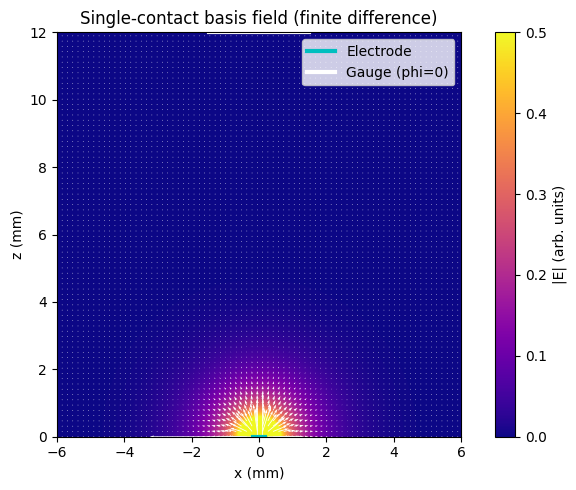

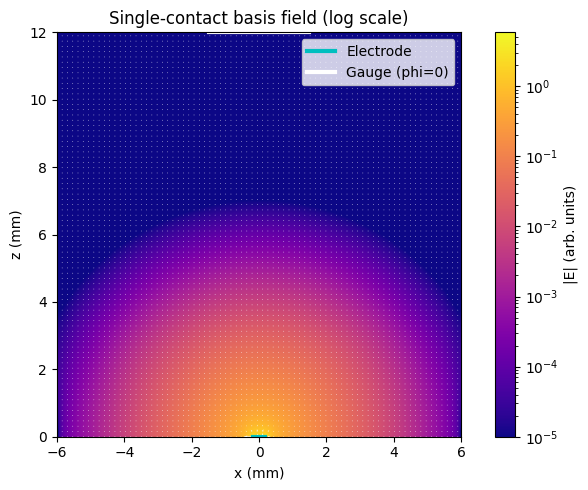

In [5]:
phi_fd = solve_laplace_fd(electrode_mask, phi_electrode=1.0, verbose=True)
Ex_fd, Ez_fd, Emag_fd = compute_field(phi_fd)
plot_field_map(Emag_fd, Ex_fd, Ez_fd, title="Single-contact basis field (finite difference)", vmax=0.5)
plot_field_map(Emag_fd, Ex_fd, Ez_fd, title="Single-contact basis field (log scale)", log_scale=True, floor=1e-5)

**Multi-contact basis and superposition**

Stamp additional electrodes by selecting their x-centres, build a basis library, then form arbitrary linear combinations (currents) exactly like the 3D contract.

In [6]:
def make_electrode_masks(centers_mm: Sequence[float], half_width_mm: float = contact_radius_mm) -> List[np.ndarray]:
    return [make_bottom_mask(cx, half_width_mm) for cx in centers_mm]


def solve_basis_library(
    centers_mm: Sequence[float],
    *,
    half_width_mm: float = contact_radius_mm,
    phi_drive: float = 1.0,
    solver_kwargs: Optional[Dict] = None,
) -> Tuple[np.ndarray, List[np.ndarray]]:
    solver_kwargs = solver_kwargs or {}
    masks = make_electrode_masks(centers_mm, half_width_mm=half_width_mm)
    bases = []
    for cx, mask in zip(centers_mm, masks):
        print(f"Solving FD basis for electrode at x = {cx} mm")
        bases.append(solve_laplace_fd(mask, phi_electrode=phi_drive, verbose=False, **solver_kwargs))
    return np.stack(bases, axis=0), masks


def combine_bases(currents: Sequence[float], phi_bases: np.ndarray) -> np.ndarray:
    currents = np.asarray(currents, dtype=np.float64).reshape(-1, 1, 1)
    return np.sum(currents * phi_bases, axis=0)

Solving FD basis for electrode at x = -0.4 mm
Solving FD basis for electrode at x = 0.0 mm
Solving FD basis for electrode at x = 0.4 mm


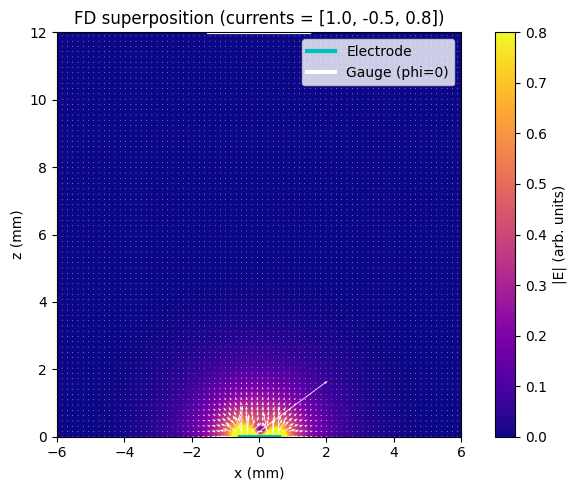

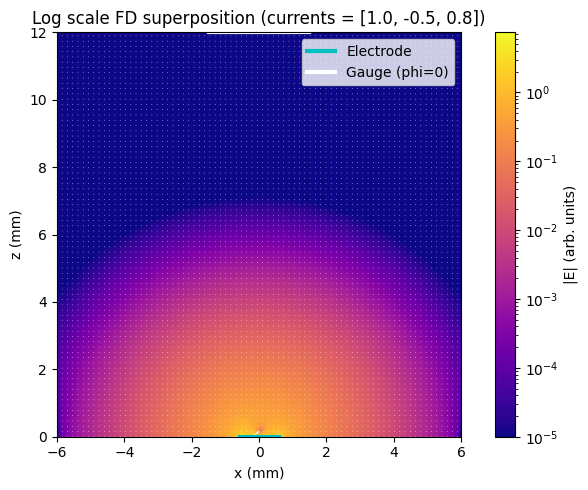

In [7]:
electrode_centers = [-0.4, 0.0, 0.4]
phi_bases_fd, masks_fd = solve_basis_library(electrode_centers)

currents_demo = [1.0, -0.5, 0.8]
phi_combo_fd = combine_bases(currents_demo, phi_bases_fd)
Ex_combo, Ez_combo, Emag_combo = compute_field(phi_combo_fd)

combined_mask = np.any(np.stack(masks_fd, axis=0), axis=0)
plot_field_map(
    Emag_combo,
    Ex_combo,
    Ez_combo,
    title=f"FD superposition (currents = {currents_demo})",
    electrode_mask=combined_mask,
    vmax=0.8,
)

plot_field_map(
    Emag_combo,
    Ex_combo,
    Ez_combo,
    title=f"Log scale FD superposition (currents = {currents_demo})",
    electrode_mask=combined_mask,
    log_scale=True, floor = 1e-5
)


## PINN Version 
**PINA: train a 2D basis field**

The helpers below wrap the Tower A Laplace problem into `TowerA2DProblem`, so you can discretise, train, and evaluate 2D basis fields with PINA exactly like the 3D pipeline.

### PINN 2D Geometry and PDE Definitions

#### **1. Geometry Setup**

The `TowerA2DGeometry` dataclass defines the **spatial domain** for the 2-D simulation:

Helper properties compute each segment’s lateral extent while ensuring they remain inside the domain.

#### **2. Boundary Type – Neumann Segments**

`NeumannSegment` is a descriptor for an **insulating or flux-controlled boundary**.  
Each instance tracks:
- which axis it lies on (`x` or `z`),  
- the sign of its outward normal (`±1`),  
- and a short descriptive name (e.g., `"outer"`, `"shank"`).  

These are used later to attach Neumann equations to the corresponding domain faces.



#### **3. Laplace Equation Definition**

`build_laplace_equation_2d()` constructs the **governing PDE** for steady-state conduction:

\[
\nabla \cdot (\sigma \nabla \phi) = 0
\]

The function uses automatic differentiation (via PINA’s `grad` and `div`) to compute:
1. the potential gradient ∇ϕ,  
2. the conductive flux **J = σ ∇ϕ**,  
3. and its divergence ∇·J.

The result is packaged as a `PINA Equation` object that enforces this residual during PINN training.



#### **4. Neumann Boundary Condition**

`build_neumann_equation_2d()` defines the boundary residual for **Neumann (flux) conditions**, which express:

\[
\mathbf{n} \cdot (\sigma \nabla \phi) = q_{\text{target}}
\]

where *qₜₐᵣₑₜ* = 0 for insulating walls, or a specified value for current-carrying contacts.  
The function:
- extracts the appropriate gradient component (x or z),  
- applies the normal-sign convention,  
- scales by conductivity,  
- and forms a residual that drives the computed flux toward the target value.

---

Together, these definitions allow the 2-D PINN version of Tower A to:
- describe the geometry and boundary structure explicitly,  
- encode Laplace’s law as a differentiable residual,  
- and impose Neumann or Dirichlet boundary conditions on the correct regions of the domain.


In [ ]:
@dataclass(frozen=True)
class TowerA2DGeometry:
    x_bounds: Tuple[float, float] = (x_min, x_max)
    z_bounds: Tuple[float, float] = (z_min, z_max)
    electrode_center_mm: float = 0.0
    contact_halfwidth_mm: float = contact_radius_mm
    gauge_center_mm: float = 0.0
    gauge_halfwidth_mm: float = gauge_radius_mm

    def _clip_interval(self, center: float, half_width: float) -> Tuple[float, float]:
        lo = max(self.x_bounds[0], center - half_width)
        hi = min(self.x_bounds[1], center + half_width)
        if hi <= lo:
            raise ValueError("Interval collapsed; widen the half-width.")
        return float(lo), float(hi)

    @property
    def electrode_span(self) -> Tuple[float, float]:
        return self._clip_interval(self.electrode_center_mm, self.contact_halfwidth_mm)

    @property
    def gauge_span(self) -> Tuple[float, float]:
        return self._clip_interval(self.gauge_center_mm, self.gauge_halfwidth_mm)


@dataclass(frozen=True)
class NeumannSegment:
    name: str
    axis: str
    normal_sign: int


from pina.operator import laplacian

def build_laplace_equation_2d(axes=('x','z')) -> Equation:
    def residual(input_: LabelTensor, output_: LabelTensor) -> LabelTensor:
        return laplacian(output_, input_, components=['phi'], d=list(axes))
    return Equation(residual)


def build_neumann_equation_2d(
    axis: str,
    normal_sign: int,
    conductivity: float,
    target_flux: float = 0.0,
    axes: Tuple[str, str] = ("x", "z"),
) -> Equation:
    axis_index = list(axes).index(axis)

    def residual(input_: LabelTensor, output_: LabelTensor) -> LabelTensor:
        grad_phi = grad(output_, input_, components=["phi"], d=list(axes)).tensor
        component = grad_phi[:, axis_index]
        flux = -conductivity * normal_sign * component
        target = torch.full_like(flux, float(target_flux))
        return LabelTensor((flux - target).unsqueeze(-1), labels=["flux"])

    return Equation(residual)

###  PINN Training Workflow


#### 1. Problem Structure

The `TowerA2DProblem` class defines a **complete boundary-value problem**
It encapsulates the geometry, material conductivity, and all boundary conditions in a single, reproducible structure.

- **Interior domain:**  
  Represents the tissue region where Laplace’s equation must hold.

- **Dirichlet boundaries:**  
  - **Electrode** — fixed potential on the bottom plane (z = 0).  
  - **Gauge patch** — fixed potential on the top plane (z = zₘₐₓ).

- **Neumann boundaries:**  
  All remaining surfaces (side walls and uncovered portions of top/bottom) are treated as **insulating** ensuring that current can only flow vertically through the tissue.

The constructor partitions the domain into these labeled sub-regions and associates each with its appropriate condition.


#### 2. Domain Discretization

In this stage, each region of the Tower A domain is populated with **collocation points** that the PINN uses during training:

- **Interior points** enforce the Laplace residual \( \nabla \cdot (\sigma \nabla \phi) = 0 \).  
- **Dirichlet points** anchor the potential on the electrode and gauge boundaries.  
- **Neumann points** maintain zero-flux behavior on all remaining faces.

These points define where the network “feels” the physics inside the domain.  
Their density directly affects accuracy — dense sampling near the electrode captures steep gradients,  
while fewer points suffice in smoother regions farther away.

At this stage the sampling is *static*: points are drawn once using either Latin-hypercube or random placement.  
Later, we will extend this step using **RoPINN (Residual-Optimized PINN)**,  
an adaptive strategy that dynamically reallocates points toward regions where the residual error is highest.  
This improvement makes training more data-efficient and greatly enhances accuracy around high-gradient zones such as electrode edges.

> **Key idea:** Domain discretization defines *where* physics are enforced —  
> RoPINN will later teach the model *where it still needs to learn more*.



#### 3. Model Representation

A small **feed-forward neural network** serves as the continuous field approximator  
\[
(x,z) \mapsto \phi_\theta(x,z)
\]
with two inputs, one output, and several hidden layers (typically 64 neurons × 6 layers, `tanh` activation).  
This configuration balances smoothness and numerical stability for harmonic potentials.



#### 4. PINN Training Procedure

The training loop constructs a composite loss that enforces both physics and boundary constraints:
\[
L = L_{\text{PDE}} + L_{\text{Dirichlet}} + L_{\text{Neumann}}
\]

- **PDE term:** penalizes violations of the Laplace residual inside the domain.  
- **Dirichlet term:** anchors the potential at the electrode and gauge.  
- **Neumann term:** enforces zero-flux boundaries.

The PINA trainer iteratively minimizes this loss using gradient descent until the potential field converges to a physically consistent solution.



#### 5. Practical Considerations and Validation

- **Conductivity units:** all parameters use millimetres (σ ≈ 2×10⁻⁴ S/mm ≡ 0.2 S/m).  
- **Normal directions:** confirm signs (+1 = outward, –1 = inward) so field polarity is correct.  
- **Sampling balance:** insufficient boundary points can cause edge leakage; ensure a few hundred per face.  
- **Monitoring:** during training, PDE loss should decrease steadily while boundary losses remain near machine precision.

After convergence, the potential should smoothly decrease from +1 V at the electrode to 0 V at the gauge, reproducing the field distribution predicted by the finite-difference baseline.


#### 6. Dual Purpose

This 2-D formulation acts as the **verification stage** for Tower A.  
It validates the correctness of:
- domain labeling and boundary construction,  
- Laplace residual implementation, and  
- network training stability.  

It also Serves as the Numerical Compuation final:
- to find a recent paper ( within a year) and to apply their work on a data set 
- intent is to showcase what we learned in the course 
- Here I compare Ropinn with regualr PINN with combinitations of injected currrent 

Once stable and physically accurate here, the same logic generalizes directly to the 3-D electrode array geometry used in the full Tower A field encoder.


In [ ]:
class TowerA2DProblem(SpatialProblem):
    output_variables = ["phi"]
    axes = ("x", "z")

    def __init__(
        self,
        geometry: TowerA2DGeometry,
        conductivity: float = 0.0002,
        phi_electrode: float = 1.0,
        phi_gauge: float = 0.0,
    ) -> None:
        self.geometry = geometry
        self.conductivity = float(conductivity)
        self.phi_electrode = float(phi_electrode)
        self.phi_gauge = float(phi_gauge)
        self.domains, self.neumann_segments, self.dirichlet_domains = self._build_domains()
        self._spatial_domain = self.domains["interior"]
        self._conditions = self._build_conditions()
        super().__init__()

    def _build_domains(self) -> Tuple[Dict[str, CartesianDomain], List[NeumannSegment], List[str]]:
        domains: Dict[str, CartesianDomain] = {}
        domains["interior"] = CartesianDomain({"x": list(self.geometry.x_bounds), "z": list(self.geometry.z_bounds)})

        dirichlet_domains: List[str] = []
        electrode_lo, electrode_hi = self.geometry.electrode_span
        domains["electrode_bc"] = CartesianDomain({"x": [electrode_lo, electrode_hi], "z": self.geometry.z_bounds[0]})
        dirichlet_domains.append("electrode_bc")

        gauge_lo, gauge_hi = self.geometry.gauge_span
        domains["gauge_bc"] = CartesianDomain({"x": [gauge_lo, gauge_hi], "z": self.geometry.z_bounds[1]})
        dirichlet_domains.append("gauge_bc")

        neumann_segments: List[NeumannSegment] = []
        x_min_loc, x_max_loc = self.geometry.x_bounds
        z_min_loc, z_max_loc = self.geometry.z_bounds

        def add_segment(name: str, *, x_range=None, z_range=None, const_x=None, const_z=None, axis="z", normal_sign=1):
            if x_range is not None and x_range[1] - x_range[0] <= 1e-9:
                return
            if z_range is not None and z_range[1] - z_range[0] <= 1e-9:
                return
            payload = {}
            if const_x is not None:
                payload["x"] = float(const_x)
            else:
                payload["x"] = [float(x_range[0]), float(x_range[1])]
            if const_z is not None:
                payload["z"] = float(const_z)
            else:
                payload["z"] = [float(z_range[0]), float(z_range[1])]
            domains[name] = CartesianDomain(payload)
            neumann_segments.append(NeumannSegment(name=name, axis=axis, normal_sign=normal_sign))

        add_segment("bottom_left", x_range=(x_min_loc, electrode_lo), const_z=z_min_loc, axis="z", normal_sign=-1)
        add_segment("bottom_right", x_range=(electrode_hi, x_max_loc), const_z=z_min_loc, axis="z", normal_sign=-1)
        add_segment("top_left", x_range=(x_min_loc, gauge_lo), const_z=z_max_loc, axis="z", normal_sign=1)
        add_segment("top_right", x_range=(gauge_hi, x_max_loc), const_z=z_max_loc, axis="z", normal_sign=1)
        add_segment("left_wall", const_x=x_min_loc, z_range=self.geometry.z_bounds, axis="x", normal_sign=-1)
        add_segment("right_wall", const_x=x_max_loc, z_range=self.geometry.z_bounds, axis="x", normal_sign=1)

        return domains, neumann_segments, dirichlet_domains

    def _build_conditions(self) -> Dict[str, Condition]:
        conditions: Dict[str, Condition] = {}
        conditions["pde"] = Condition(
            domain="interior",
            equation=build_laplace_equation_2d(self.conductivity, axes=self.axes),
        )
        conditions["electrode"] = Condition(
            domain="electrode_bc",
            equation=FixedValue(self.phi_electrode, components=["phi"]),
        )
        conditions["gauge"] = Condition(
            domain="gauge_bc",
            equation=FixedValue(self.phi_gauge, components=["phi"]),
        )
        for seg in self.neumann_segments:
            eq = build_neumann_equation_2d(seg.axis, seg.normal_sign, self.conductivity, axes=self.axes)
            conditions[f"neumann:{seg.name}"] = Condition(domain=seg.name, equation=eq)
        return conditions

    @property
    def spatial_domain(self):
        return self._spatial_domain

    @property
    def conditions(self) -> Dict[str, Condition]:
        return self._conditions


def discretise_2d_problem(
    problem: TowerA2DProblem,
    *,
    interior_points: int = 20_000,
    dirichlet_points: int = 512,
    neumann_points: int = 1_024,
    interior_mode: str = "latin",
    boundary_mode: str = "random",
) -> None:
    problem.discretise_domain(n=interior_points, mode=interior_mode, domains="interior")
    for name in problem.dirichlet_domains:
        problem.discretise_domain(n=max(1, dirichlet_points), mode=boundary_mode, domains=name)
    for seg in problem.neumann_segments:
        problem.discretise_domain(n=max(1, neumann_points), mode=boundary_mode, domains=seg.name)


def build_default_model(hidden_size: int = 64, n_layers: int = 6, activation: type[nn.Module] = nn.Tanh) -> nn.Module:
    return FeedForward(
        input_dimensions=2,
        output_dimensions=1,
        inner_size=hidden_size,
        n_layers=n_layers,
        func=activation,
    )


def train_pinn_basis(
    *,
    electrode_center_mm: float = 0.0,
    contact_halfwidth_mm: float = contact_radius_mm,
    gauge_halfwidth_mm: float = gauge_radius_mm,
    conductivity_S_per_mm: float = 0.0002,
    phi_drive: float = 1.0,
    phi_gauge: float = 0.0,
    interior_points: int = 20_000,
    dirichlet_points: int = 512,
    neumann_points: int = 1_024,
    max_epochs: int = 2_000,
    hidden_size: int = 64,
    n_layers: int = 6,
    activation: type[nn.Module] = nn.Tanh,
    model: Optional[nn.Module] = None,
) -> Dict[str, object]:
    geometry = TowerA2DGeometry(
        x_bounds=(x_min, x_max),
        z_bounds=(z_min, z_max),
        electrode_center_mm=electrode_center_mm,
        contact_halfwidth_mm=contact_halfwidth_mm,
        gauge_center_mm=0.0,
        gauge_halfwidth_mm=gauge_halfwidth_mm,
    )
    problem = TowerA2DProblem(
        geometry=geometry,
        conductivity=conductivity_S_per_mm,
        phi_electrode=phi_drive,
        phi_gauge=phi_gauge,
    )
    discretise_2d_problem(
        problem,
        interior_points=interior_points,
        dirichlet_points=dirichlet_points,
        neumann_points=neumann_points,
    )
    model = model or build_default_model(hidden_size=hidden_size, n_layers=n_layers, activation=activation)
    model = model.to(device)
    solver = PINN(problem=problem, model=model)
    trainer = Trainer(
        solver=solver,
        max_epochs=max_epochs,
        train_size=1.0,
        val_size=0.0,
        test_size=0.0,
        batch_size=None,
        accelerator="auto",
        devices=1,
    )
    trainer.train()
    return {
        "geometry": geometry,
        "problem": problem,
        "model": model,
        "solver": solver,
        "trainer": trainer,
    }

we need to extract the learned potential field
and compare it against the finite-difference (FD) reference solution.

---

#### **1. Extracting the Potential (`_extract_phi_tensor`)**

Because PINA models can return outputs wrapped inside different data structures
(e.g., `LabelTensor` or plain `Tensor`), this helper standardizes the extraction of the
predicted potential \( \phi(x, z) \).
It ensures we always end up with a clean 2-D tensor of potential values that can be reshaped
onto the spatial grid for visualization or derivative calculations.


#### **2. Evaluating the Model on a Grid**

`evaluate_model_on_grid()` samples the trained network across the same regular grid
used by the FD solver.  
Each coordinate pair \((x_i, z_j)\) is passed through the model to obtain
the predicted potential \( \phi_{\text{PINN}}(x_i, z_j) \).  
The result is reshaped into a 2-D field that can be plotted directly
or used for numerical comparison.

This step gives the continuous neural representation of the potential field,
allowing smooth interpolation between grid points.



#### **3. Computing the Electric Field from the Model**

`compute_field_from_model()` derives the **electric field components**
directly from the learned potential using automatic differentiation:

\[
E_x = -\frac{\partial \phi}{\partial x}, \qquad
E_z = -\frac{\partial \phi}{\partial z}, \qquad
|E| = \sqrt{E_x^2 + E_z^2}.
\]

This takes advantage of PyTorch’s gradient tracing to compute spatial derivatives
exactly from the trained network — no finite differences required.
The output includes both field components and the total magnitude,
mirroring the same quantities computed earlier in the FD reference.



#### **4. Comparing FD and PINN Results**

`compare_fd_to_pinn()` visualizes how well the PINN reproduces the FD solution.
It computes the relative L₂ error and shows a color-map of
\(\phi_{\text{PINN}} - \phi_{\text{FD}}\) across the domain.

- **Blue / red regions** indicate where the PINN under- or over-predicts potential.  
- **Uniform near-zero coloration** confirms close agreement and successful training.

This comparison is the final validation step for the Tower A 2-D workflow:
if the error map is flat and the L₂ error is small (≈10⁻³ – 10⁻⁴),
the PINN has accurately learned the same physics encoded in the finite-difference model.


> **Next step:** Once verified against the FD baseline, this same evaluation pipeline
> will be reused when testing **RoPINN-enhanced training**, allowing direct visual
> and numerical comparison of accuracy improvements in high-gradient regions.


In [ ]:
def _extract_phi_tensor(outputs: object) -> torch.Tensor:
    if hasattr(outputs, 'extract'):
        try:
            extracted = outputs.extract(['phi']).tensor
        except Exception:
            extracted = getattr(outputs, 'tensor', outputs)
    elif hasattr(outputs, 'tensor'):
        extracted = outputs.tensor
    else:
        extracted = outputs
    if isinstance(extracted, torch.Tensor):
        if extracted.ndim == 2 and extracted.shape[-1] == 1:
            extracted = extracted.squeeze(-1)
        return extracted
    return torch.as_tensor(extracted)


def evaluate_model_on_grid(
    model: nn.Module,
    *,
    x_coords: np.ndarray = x,
    z_coords: np.ndarray = z,
    device: torch.device = device,
) -> np.ndarray:
    model.eval()
    grid_x, grid_z = np.meshgrid(x_coords, z_coords, indexing='ij')
    coords = np.stack([grid_x.ravel(), grid_z.ravel()], axis=-1)
    coords_tensor = torch.tensor(coords, dtype=torch.float32, device=device)
    coords_lt = LabelTensor(coords_tensor, labels=['x', 'z'])
    with torch.no_grad():
        outputs = model(coords_lt)
        phi_tensor = _extract_phi_tensor(outputs)
    phi = phi_tensor.detach().cpu().numpy().reshape(len(x_coords), len(z_coords))
    return phi


def compute_field_from_model(
    model: nn.Module,
    *,
    x_coords: np.ndarray = x,
    z_coords: np.ndarray = z,
    device: torch.device = device,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    model.eval()
    grid_x, grid_z = np.meshgrid(x_coords, z_coords, indexing='ij')
    coords = np.stack([grid_x.ravel(), grid_z.ravel()], axis=-1)
    coords_tensor = torch.tensor(coords, dtype=torch.float32, device=device, requires_grad=True)
    coords_lt = LabelTensor(coords_tensor, labels=['x', 'z'])
    outputs = model(coords_lt)
    phi_tensor = _extract_phi_tensor(outputs)
    grads = torch.autograd.grad(
        phi_tensor,
        coords_tensor,
        grad_outputs=torch.ones_like(phi_tensor),
        create_graph=False,
        retain_graph=False,
    )[0]
    grad_x = grads[:, 0].detach().cpu().numpy().reshape(len(x_coords), len(z_coords))
    grad_z = grads[:, 1].detach().cpu().numpy().reshape(len(x_coords), len(z_coords))
    Ex = -grad_x
    Ez = -grad_z
    Emag = np.sqrt(Ex**2 + Ez**2)
    phi = phi_tensor.detach().cpu().numpy().reshape(len(x_coords), len(z_coords))
    return phi, Ex, Ez, Emag


def compare_fd_to_pinn(phi_fd: np.ndarray, phi_pinn: np.ndarray) -> None:
    diff = phi_pinn - phi_fd
    rel_l2 = np.linalg.norm(diff) / np.linalg.norm(phi_fd)
    print(f'Relative L2 error = {rel_l2:.3e}; max |phi diff| = {np.max(np.abs(diff)):.3e}')
    plt.figure(figsize=(6, 4))
    plt.imshow(
        diff.T,
        extent=[x_min, x_max, z_min, z_max],
        aspect='equal',
        cmap='coolwarm',
    )
    plt.colorbar(label='phi_PINN - phi_FD')
    plt.xlabel('x (mm)')
    plt.ylabel('z (mm)')
    plt.title('PINN vs FD potential difference')
    plt.tight_layout()
    plt.show()


### Quick smoke test
Set `RUN_SMOKE = True` to launch a short training pass (about a minute on CPU). Leaving it `False` avoids accidental long runs and still prints this reminder so the cell is never silent.

In [9]:
RUN_SMOKE = True
if RUN_SMOKE:
    print('Starting 2D PINN smoke run...')
    smoke = train_pinn_basis(
        electrode_center_mm=0.0,
        contact_halfwidth_mm=contact_radius_mm,
        interior_points=5_000,
        dirichlet_points=256,
        neumann_points=512,
        max_epochs=100,
        hidden_size=64,
    )
    print('Training complete. Evaluating model on the FD grid...')
    phi_pinn, Ex_pinn, Ez_pinn, Emag_pinn = compute_field_from_model(smoke['model'])
    compare_fd_to_pinn(phi_fd, phi_pinn)
    plot_field_map(
        Emag_pinn,
        Ex_pinn,
        Ez_pinn,
        title='PINN basis (smoke)',
        electrode_mask=electrode_mask,
        vmax=0.5,
    )
else:
    print('Set RUN_SMOKE = True above to launch the PINN training demo.')

Starting 2D PINN smoke run...


NameError: name 'train_pinn_basis' is not defined

### RoPINN-style sampling (Wu et al., 2023)
[RoPINN: Region Optimized Physics-Informed Neural Networks](Documents/RoPINN.pdf) augments each collocation point with a small trust region to improve generalisation. Toggle `RUN_RO_COMPARISON` below to train the vanilla random sampler and the RoPINN-style sampler back-to-back, then compare their error metrics and |?f| maps against the finite-difference reference.

In [ ]:

RUN_RO_COMPARISON = True
if RUN_RO_COMPARISON:
    base_kwargs = dict(
        electrode_center_mm=0.0,
        contact_halfwidth_mm=contact_radius_mm,
        interior_points=8_000,
        dirichlet_points=768,
        neumann_points=768,
        interior_boost=6,
        dirichlet_boost=2,
        max_epochs=700,
        hidden_size=64,
        normalize_inputs=True,
        early_stop_patience=150,
        early_stop_min_delta=1e-5,
    )

    ro_repeats = 4
    fairness_factor = ro_repeats

    print('Training baseline PINN with random sampling (fairness-adjusted points)...')
    random_kwargs = dict(base_kwargs)
    random_kwargs.update(
        sampler='random',
        interior_points=base_kwargs['interior_points'] * fairness_factor,
        ro_radius_mm=0.0,
        ro_repeats=0,
    )
    random_run = train_pinn_basis(**random_kwargs)
    phi_random = evaluate_model_on_grid(random_run['model'])
    random_metrics = compute_fd_metrics(phi_random)
    report_boundary_stats(phi_random, label='random sampler')
    rand_res_mean, rand_res_p95 = laplacian_stats(random_run['model'], random_run['geometry'])
    print(f'Random sampler residual mean={rand_res_mean:.2e}, 95th%={rand_res_p95:.2e}')

    print('Training RoPINN-style PINN with trust-region sampling...')
    ro_kwargs = dict(base_kwargs)
    ro_kwargs.update(
        sampler='ropinn',
        ro_radius_mm=0.35,
        ro_repeats=ro_repeats,
        ro_z_focus_mm=2.0,
    )
    ro_run = train_pinn_basis(**ro_kwargs)
    phi_ro = evaluate_model_on_grid(ro_run['model'])
    ro_metrics = compute_fd_metrics(phi_ro)
    report_boundary_stats(phi_ro, label='RoPINN sampler')
    ro_res_mean, ro_res_p95 = laplacian_stats(ro_run['model'], ro_run['geometry'])
    print(f'RoPINN residual mean={ro_res_mean:.2e}, 95th%={ro_res_p95:.2e}')

    print('Finite-difference vs PINN summaries (φ normalised to FD scale):')
    summary_rows = [
        ('Finite difference (reference)', 0.0, 0.0),
        ('PINN random sampler', random_metrics['rel_l2'], random_metrics['max_abs']),
        ('RoPINN sampler', ro_metrics['rel_l2'], ro_metrics['max_abs']),
    ]
    print_metrics_table(summary_rows)

    plot_difference_gallery(
        [
            ('PINN random - FD', random_metrics['diff']),
            ('RoPINN - FD', ro_metrics['diff']),
        ]
    )
else:
    print('Set RUN_RO_COMPARISON = True to train a RoPINN-style model alongside the random baseline.')


In [ ]:
def describe_discretisation(run):
    prob = run['problem']
    print(f"phi_electrode={prob.phi_electrode}, phi_gauge={prob.phi_gauge}")
    names = [
        'interior','electrode_bc','gauge_bc',
        'bottom_left','bottom_right','top_left','top_right','left_wall','right_wall',
    ]
    for name in names:
        lt = prob.discretised_domains.get(name)
        if lt is None:
            print(f"{name:14s}: MISSING")
            continue
        T = lt.tensor
        xmin, xmax = float(T[:,0].min()), float(T[:,0].max())
        zmin, zmax = float(T[:,1].min()), float(T[:,1].max())
        print(f"{name:14s}: {len(T):6d}  x∈[{xmin:+.3f},{xmax:+.3f}]  z∈[{zmin:+.3f},{zmax:+.3f}]")

describe_discretisation(smoke)  # or random_run / ro_run


In [ ]:
phi_pinn, Ex_pinn, Ez_pinn, Emag_pinn = compute_field_from_model(smoke['model'])
report_boundary_stats(phi_pinn, label='PINN')


In [ ]:
phi_pinn, Ex_pinn, Ez_pinn, Emag_pinn = compute_field_from_model(smoke['model'])

# A. Boundary stats
report_boundary_stats(phi_pinn, label='PINN')

# B. Centerline potential
ix0 = np.argmin(np.abs(x-0.0))
plt.plot(z, phi_fd[ix0], label='FD')
plt.plot(z, phi_pinn[ix0], label='PINN')
plt.xlabel('z (mm)'); plt.ylabel('phi (V)'); plt.legend(); plt.show()

# C. Are we just plotting with too-big a color scale?
v = np.quantile(Emag_pinn, 0.995)  # robust max
plot_field_map(Emag_pinn, Ex_pinn, Ez_pinn, title='PINN |E| (auto scale)', vmax=float(v))
